# Explore Calibrated Data

In [1]:
import ctapipe
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u
import numpy as np
%matplotlib inline
plt.style.use("ggplot")

/usr/local/lib/python3.8/site-packages/setuptools_scm/git.py:68: UserWarning: "/github/workspace" is shallow and may cause errors
  warnings.warn('"{}" is shallow and may cause errors'.format(wd.path))


In [2]:
print(ctapipe.__version__)
print(ctapipe.__file__)

0.1.dev1+gddc003f
/github/workspace/ctapipe/__init__.py


Let's first open a raw event file and get an event out of it:

In [3]:
filename = get_dataset_path("gamma_test.simtel.gz")
source = EventSource(filename, max_events=2)

for event in source:
    print(event.index.event_id)

/github/workspace/ctapipe/io/simteleventsource.py:68: UnknownPixelShapeWarning: Unkown pixel_shape -1.0 for camera_type LSTCam
  warnings.warn(
/github/workspace/ctapipe/io/simteleventsource.py:68: UnknownPixelShapeWarning: Unkown pixel_shape -1.0 for camera_type NectarCam
  warnings.warn(
/github/workspace/ctapipe/io/simteleventsource.py:68: UnknownPixelShapeWarning: Unkown pixel_shape -1.0 for camera_type CHEC
  warnings.warn(
/github/workspace/ctapipe/io/simteleventsource.py:68: UnknownPixelShapeWarning: Unkown pixel_shape -1.0 for camera_type SCTCam
  warnings.warn(


408
409


In [4]:
filename

PosixPath('/github/home/.cache/ctapipe/gamma_test.simtel.gz')

In [5]:
source

allowed_tels,None,"list of allowed tel_ids, others will be ignored. If None, all telescopes in the input stream will be included (default: None)"
back_seekable,False,Require the event source to be backwards seekable. This will reduce in slower read speed for gzipped files and is not possible for zstd compressed files (default: False)
focal_length_choice,nominal,"if both nominal and effective focal lengths are available in the SimTelArray file, which one to use when constructing the SubarrayDescription (which will be used in CameraFrame to TelescopeFrame coordinate transforms. The 'nominal' focal length is the one used during the simulation, the 'effective' focal length is computed using specialized ray-tracing from a point light source (default: nominal)"
gain_selector_type,ThresholdGainSelector,GainSelector to use. (default: ThresholdGainSelector)
input_url,/github/home/.cache/ctapipe/gamma_test.simtel.gz,Path to the input file containing events. (default: None)
max_events,2,Maximum number of events that will be read from the file (default: None)
skip_calibration_events,True,Skip calibration events (default: True)


In [6]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                  simulation.*: Simulated Event Information
                     trigger.*: central trigger information
                         count: number of events processed
                    pointing.*: Array and telescope pointing positions
                 calibration.*: Container for calibration coefficients for the
                                current event
                         mon.*: container for event-wise monitoring data (MON)

In [7]:
print(event.r1)

{'tel': {11: {'selected_gain_channel': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
              'waveform': array([[-0.08697608,  0.18923593,  0.18923593, ...,  0.58820885,
         0.03578481, -0.17904675],
       [ 0.65603745,  0.65603745,  0.16448696, ..., -0.22875345,
        -0.5236837 , -0.13044335],
       [-0.31448284, -0.15485168, -0.12292545, ..., -0.21870415,
        -0.15485168, -0.28255662],
       ...,
       [-0.2288092 ,  0.1161234 , -0.04066414, ...,  0.02205088,
        -0.07202165,  0.02205088],
       [ 0.0596489 , -0.06216849, -0.09262283, ..., -0.18398587,
        -0.36671194, -0.12307718],
       [-0.38044545, -0.24650918,  0.05484743, ...,  0.52362436,
         0.55710846,  0.52362436]], dtype=float32)},
         21: {'selected_gain_channel': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
              'waveform': array([[-0.23289204, -0.2635209 , -0.07974766, ..., -0.04911879,
         0.01213896, -0.17163429],
       [ 1.1236377 ,  0.5958728 ,  0.25437793, ..., 

## Perform basic calibration:

Here we will use a `CameraCalibrator` which is just a simple wrapper that runs the three calibraraton and trace-integration phases of the pipeline, taking the data from levels:

  **R0** &rightarrow; **R1** &rightarrow; **DL0** &rightarrow; **DL1**

You could of course do these each separately, by using the classes `R1Calibrator`, `DL0Reducer`, and `DL1Calibrator`.
Note that we have not specified any configuration to the `CameraCalibrator`, so it will be using the default algorithms and thresholds, other than specifying that the product is a "HESSIOR1Calibrator" (hopefully in the near future that will be automatic).

In [8]:
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(subarray=source.subarray)
calib(event)

Now the *r1*, *dl0* and *dl1* containers are filled in the event

* **r1.tel[x]**: contains the "r1-calibrated" waveforms, after gain-selection, pedestal subtraciton, and gain-correction
* **dl0.tel[x]**: is the same but with optional data volume reduction (some pixels not filled), in this case this is not performed by default, so it is the same as r1
* **dl1.tel[x]**: contains the (possibly re-calibrated) waveforms as dl0, but also the time-integrated *image* that has been calculated using a `ImageExtractor` (a `NeighborPeakWindowSum` by default)

In [9]:
for tel_id in event.dl1.tel:
    print("TEL{:03}: {}".format(tel_id, source.subarray.tel[tel_id]))
    print("  - r0  wave shape  : {}".format(event.r0.tel[tel_id].waveform.shape))
    print("  - r1  wave shape  : {}".format(event.r1.tel[tel_id].waveform.shape))
    print("  - dl1 image shape : {}".format(event.dl1.tel[tel_id].image.shape))

TEL011: MST_MST_NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1855, 30)
  - dl1 image shape : (1855,)
TEL021: MST_MST_NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1855, 30)
  - dl1 image shape : (1855,)
TEL024: MST_MST_NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1855, 30)
  - dl1 image shape : (1855,)
TEL026: MST_MST_NectarCam
  - r0  wave shape  : (1, 1855, 30)
  - r1  wave shape  : (1855, 30)
  - dl1 image shape : (1855,)
TEL061: SST_ASTRI_CHEC
  - r0  wave shape  : (1, 2048, 25)
  - r1  wave shape  : (2048, 25)
  - dl1 image shape : (2048,)
TEL063: SST_ASTRI_CHEC
  - r0  wave shape  : (1, 2048, 25)
  - r1  wave shape  : (2048, 25)
  - dl1 image shape : (2048,)
TEL118: MST_SCT_SCTCam
  - r0  wave shape  : (1, 11328, 32)
  - r1  wave shape  : (11328, 32)
  - dl1 image shape : (11328,)
TEL119: MST_SCT_SCTCam
  - r0  wave shape  : (1, 11328, 32)
  - r1  wave shape  : (11328, 32)
  - dl1 image shape : (11328,)


## Some image processing:

Let's look at the image

In [10]:
from ctapipe.visualization import CameraDisplay
tel_id = sorted(event.r1.tel.keys())[1]
sub = source.subarray
geometry = sub.tel[tel_id].camera.geometry
image = event.dl1.tel[tel_id].image

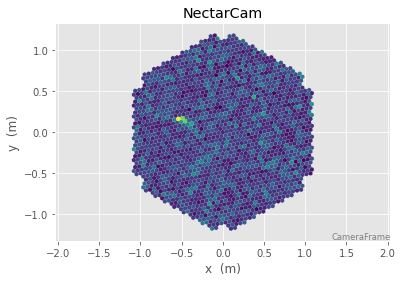

In [11]:
disp = CameraDisplay(geometry, image=image)

In [12]:
from ctapipe.image import tailcuts_clean, hillas_parameters

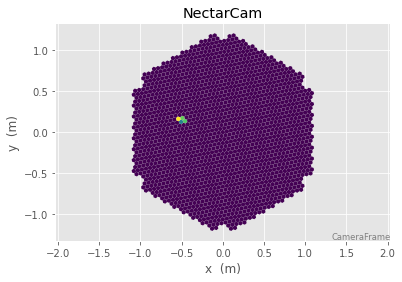

In [13]:
mask = tailcuts_clean(geometry, image, picture_thresh=10, boundary_thresh=5, min_number_picture_neighbors=2)
cleaned = image.copy()
cleaned[~mask] = 0
disp = CameraDisplay(geometry, image=cleaned)


In [14]:
params = hillas_parameters(geometry, cleaned)
print(params)
params

{'intensity': 40.55668926239014,
 'kurtosis': 1.7355258945159615,
 'length': <Quantity 0.0329767 m>,
 'length_uncertainty': <Quantity 0.00222047 m>,
 'phi': <Angle 2.85056754 rad>,
 'psi': <Angle -0.32029021 rad>,
 'r': <Quantity 0.52409634 m>,
 'skewness': 0.15350147214718432,
 'width': <Quantity 0.01579441 m>,
 'width_uncertainty': <Quantity 0.00150044 m>,
 'x': <Quantity -0.50205821 m>,
 'y': <Quantity 0.15038126 m>}


ctapipe.containers.HillasParametersContainer:
                     intensity: total intensity (size)
                             x: centroid x coordinate [m]
                             y: centroid x coordinate [m]
                             r: radial coordinate of centroid [m]
                           phi: polar coordinate of centroid [deg]
                        length: standard deviation along the major-axis [m]
            length_uncertainty: uncertainty of length [m]
                         width: standard spread along the minor-axis [m]
             width_uncertainty: uncertainty of width [m]
                           psi: rotation angle of ellipse [deg]
                      skewness: measure of the asymmetry
                      kurtosis: measure of the tailedness

(-0.34961873844871744, 0.6503812615512825)

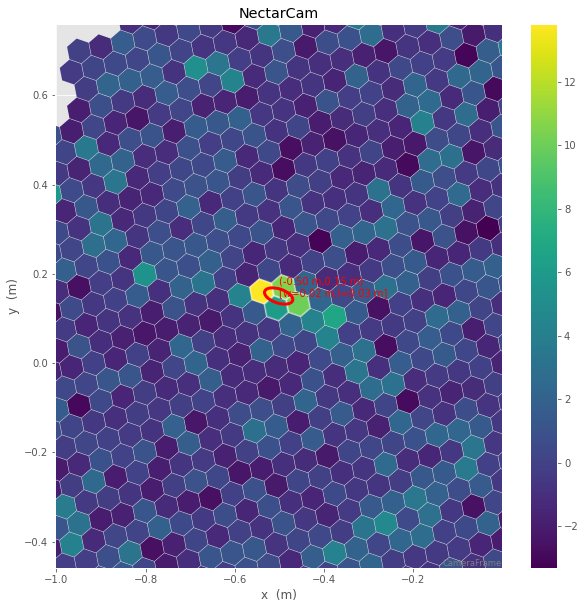

In [15]:
params = hillas_parameters(geometry, cleaned)

plt.figure(figsize=(10,10))
disp = CameraDisplay(geometry, image=image)
disp.add_colorbar()
disp.overlay_moments(params, color='red', lw=3)
disp.highlight_pixels(mask, color='white', alpha=0.3, linewidth=2)

plt.xlim(params.x.to_value(u.m) - 0.5, params.x.to_value(u.m) + 0.5)
plt.ylim(params.y.to_value(u.m) - 0.5, params.y.to_value(u.m) + 0.5)

In [16]:
source.metadata

{'is_simulation': False}

## More complex image processing:

Let's now explore how stereo reconstruction works. 

### first, look at a summed image from multiple telescopes

For this, we want to use a `CameraDisplay` again, but since we can't sum and display images with different cameras, we'll just sub-select images from a particular camera type

These are the telescopes that are in this event:

In [17]:
tels_in_event = set(event.dl1.tel.keys())  # use a set here, so we can intersect it later
tels_in_event

{11, 21, 24, 26, 61, 63, 118, 119}

In [18]:
cam_ids = set(sub.get_tel_ids_for_type("MST_MST_NectarCam"))
cam_ids

{5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28}

In [19]:
cams_in_event = tels_in_event.intersection(cam_ids)
first_tel_id = list(cams_in_event)[0]
tel = sub.tel[first_tel_id]
print("{}s in event: {}".format(tel, cams_in_event))

MST_MST_NectarCams in event: {24, 26, 11, 21}


Now, let's sum those images:

In [20]:
image_sum = np.zeros_like(tel.camera.geometry.pix_x.value)  # just make an array of 0's in the same shape as the camera 

for tel_id in cams_in_event:
    image_sum += event.dl1.tel[tel_id].image

And finally display the sum of those images

Text(0.5, 1.0, 'Sum of 4x MST_MST_NectarCam')

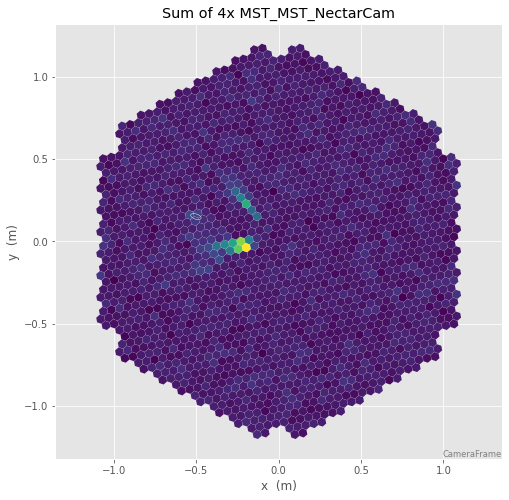

In [21]:
plt.figure(figsize=(8,8))

disp = CameraDisplay(tel.camera.geometry, image=image_sum)
disp.overlay_moments(params, with_label=False)
plt.title("Sum of {}x {}".format(len(cams_in_event), tel))

let's also show which telescopes those were. Note that currently ArrayDisplay's value field is a vector by `tel_index`, not `tel_id`, so we have to convert to a tel_index. (this may change in a future version to be more user-friendly)


In [22]:
from ctapipe.visualization import ArrayDisplay

<Figure size 432x288 with 0 Axes>

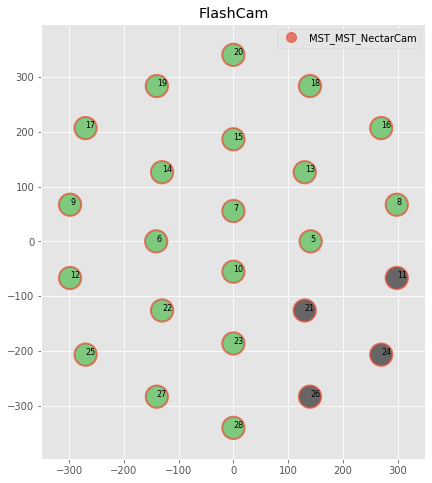

In [23]:
nectarcam_subarray = sub.select_subarray("FlashCam", cam_ids)

hit_pattern = np.zeros(shape=nectarcam_subarray.num_tels)
hit_pattern[[nectarcam_subarray.tel_indices[x] for x in cams_in_event ]] = 100

plt.set_cmap(plt.cm.Accent)
plt.figure(figsize=(8,8))

ad = ArrayDisplay(nectarcam_subarray)
ad.values = hit_pattern
ad.add_labels()
